In [6]:
from dotenv import load_dotenv
load_dotenv()
import logging
import numpy as np
import pandas as pd
import torch
from src.logger.cometml import CometMLWriter
logger = logging.getLogger("smoke")
project_config = {"trainer": {"resume_from": None}, "note": "smoke"}
writer = CometMLWriter(
    logger=logger,
    project_config=project_config,
    project_name="asr-hw",
    workspace="progphys",
    run_name="smoke-test",
    mode="online",
)

writer.set_step(0, mode="demo")
writer.add_scalar("loss", 1.0)

writer.set_step(1, mode="demo")
writer.add_image("img", (np.random.rand(32, 64) * 255).astype(np.uint8))

sr = 16000
t = torch.linspace(0, 1, sr)

audio_3ch_torch = torch.stack([
    torch.sin(2 * torch.pi * 220 * t),
    torch.sin(2 * torch.pi * 440 * t),
    torch.sin(2 * torch.pi * 880 * t),
], dim=0) 

writer.set_step(2, mode="demo")
writer.add_audio("sine_3ch_torch", audio_3ch_torch, sample_rate=sr)

t_np = np.linspace(0, 1, sr, endpoint=False)
audio_3ch_np = np.stack([
    np.sin(2 * np.pi * 220 * t_np),
    np.sin(2 * np.pi * 440 * t_np),
    np.sin(2 * np.pi * 880 * t_np),
], axis=1).astype(np.float32)   


writer.set_step(3, mode="demo")
writer.add_audio("sine_3ch_numpy", audio_3ch_np, sample_rate=sr)


writer.set_step(4, mode="demo")
writer.add_audio("from_file_3ch", "test.wav")

writer.add_text("pred", "hello")
writer.add_histogram("h", torch.randn(1000))

writer.add_table("t", pd.DataFrame({"a":[1,2], "b":[3,4]}))

writer.exp.end()


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/progphys/asr-hw/f8fff82d17f34cebbcb0db9b4c3801c6

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : smoke-test
COMET INFO:     url                   : https://www.comet.com/progphys/asr-hw/f8fff82d17f34cebbcb0db9b4c3801c6
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss_demo              : 1.0
COMET INFO:     steps_per_sec_demo [4] : (52.873684767

[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 8.6291738e-02  1.7193973e-01  3.3875823e-01]
 [ 1.7193973e-01  3.3875823e-01  6.3745725e-01]
 ...
 [-1.7185840e-01 -3.3860287e-01 -6.3720274e-01]
 [-8.6304612e-02 -1.7196518e-01 -3.3880684e-01]
 [ 1.3670491e-05  2.7340982e-05  5.4681965e-05]]


In [8]:
#check ctc decode

from src.text_encoder.ctc_text_encoder import CTCTextEncoder

model = CTCTextEncoder()
fake_inds = torch.tensor([0, 2, 2, 0, 3, 3, 3, 0, 4], dtype=torch.long)
print(model.ctc_decode(fake_inds))
print(model.decode(fake_inds))


bcd
bbcccd


In [1]:
from src.metrics.utils import calc_cer,calc_wer
#chatgpt generate tests
eps = 1e-6

tests = [
    ("", "", 0.0, 0.0),
    ("", "a", 1.0, 1.0),
    ("abcd", "aecd", 0.25, 1.0),
    ("abcd", "", 1.0, 1.0),
    ("abcd", "abbcd", 0.25, 1.0),
    ("a b c", "a b", None, 1/3),
    ("a b", "a x b", None, 0.5),
]

for t, p, cer_exp, wer_exp in tests:
    cer = calc_cer(t, p)
    wer = calc_wer(t, p)

    if cer_exp is not None:
        assert abs(cer - cer_exp) < eps, (t, p, cer, cer_exp)

    if wer_exp is not None:
        assert abs(wer - wer_exp) < eps, (t, p, wer, wer_exp)


In [2]:
import torch
from torch.utils.data import DataLoader
from omegaconf import OmegaConf
from hydra.utils import instantiate

from src.datasets.collate import collate_fn
from src.text_encoder import CTCTextEncoder

datasets_cfg = OmegaConf.load("src/configs/datasets/onebatchtest.yaml")
instance_tf_cfg = OmegaConf.load("src/configs/transforms/instance_transforms/example.yaml")


instance_transforms_train = {k: instantiate(v) for k, v in instance_tf_cfg.train.items()}
instance_transforms_infer = {k: instantiate(v) for k, v in instance_tf_cfg.inference.items()}


text_encoder = CTCTextEncoder()


ds_train = instantiate(
    datasets_cfg.train,
    instance_transforms=instance_transforms_train,
    text_encoder=text_encoder,
)
ds_val = instantiate(
    datasets_cfg.val,
    instance_transforms=instance_transforms_infer,
    text_encoder=text_encoder,
)

print("len(train) =", len(ds_train))
print("len(val)   =", len(ds_val))


item = ds_train[0]
print("keys:", list(item.keys()))
print("audio:", item["audio"].shape, item["audio"].dtype)
print("spectrogram:", item["spectrogram"].shape, item["spectrogram"].dtype)
print("text:", item["text"][:120])
print("text_encoded:", item["text_encoded"].shape, item["text_encoded"].dtype)
print("audio_path:", item["audio_path"])


assert isinstance(item["audio"], torch.Tensor)
assert item["audio"].dim() == 2 and item["audio"].size(0) == 1, "audio must be (1, T)"

assert isinstance(item["spectrogram"], torch.Tensor)
assert item["spectrogram"].dim() in (2, 3), "spectrogram must be 2D or 3D"

assert isinstance(item["text"], str)
assert isinstance(item["text_encoded"], torch.Tensor)
assert item["text_encoded"].dim() in (1, 2), "text_encoded must be 1D or 2D"

print("item sanity OK")


/home/humtech/EduMaterials/DL/DLA/HW2/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/humtech/EduMaterials/DL/DLA/HW2/.venv/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


len(train) = 2
len(val)   = 2
keys: ['audio', 'spectrogram', 'text', 'text_encoded', 'audio_path']
audio: torch.Size([1, 53120]) torch.float32
spectrogram: torch.Size([1, 128, 266]) torch.float32
text: the two stray kittens gradually make themselves at home
text_encoded: torch.Size([1, 55]) torch.float32
audio_path: /home/humtech/EduMaterials/DL/DLA/HW2/data/datasets/librispeech/dev-clean/1988/24833/1988-24833-0000.flac
item sanity OK


/home/humtech/EduMaterials/DL/DLA/HW2/.venv/lib/python3.11/site-packages/torch_audiomentations/core/transforms_interface.py:76: FutureWarning: Transforms now expect an `output_type` argument that currently defaults to 'tensor', will default to 'dict' in v0.12, and will be removed in v0.13. Make sure to update your code to something like:
  >>> augment = Gain(..., output_type='dict')
  >>> augmented_samples = augment(samples).samples
  warnings.warn(
/home/humtech/EduMaterials/DL/DLA/HW2/.venv/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [3]:
loader = DataLoader(
    ds_train,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn,
)

batch = next(iter(loader))

print("\n--- batch ---")
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

B = batch["audio"].size(0)

# required keys
for k in ["audio", "audio_length", "spectrogram", "spectrogram_length", "text_encoded", "text_encoded_length"]:
    assert k in batch, f"missing key in batch: {k}"

# audio
assert batch["audio"].shape[0] == B and batch["audio"].shape[1] == 1
assert batch["audio_length"].shape == (B,)

# spectrogram
assert batch["spectrogram"].dim() == 3  # (B, n_mels, T)
assert batch["spectrogram_length"].shape == (B,)

# text_encoded
assert batch["text_encoded"].dim() == 2  # (B, L)
assert batch["text_encoded"].dtype == torch.long
assert batch["text_encoded_length"].shape == (B,)

print("batch sanity OK")



--- batch ---
audio torch.Size([2, 1, 126320]) torch.float32
audio_length torch.Size([2]) torch.int64
spectrogram torch.Size([2, 128, 632]) torch.float32
spectrogram_length torch.Size([2]) torch.int64
text_encoded torch.Size([2, 133]) torch.int64
text_encoded_length torch.Size([2]) torch.int64
text <class 'list'> 2
audio_path <class 'list'> 2
batch sanity OK


TEXT:
the two stray kittens gradually make themselves at home


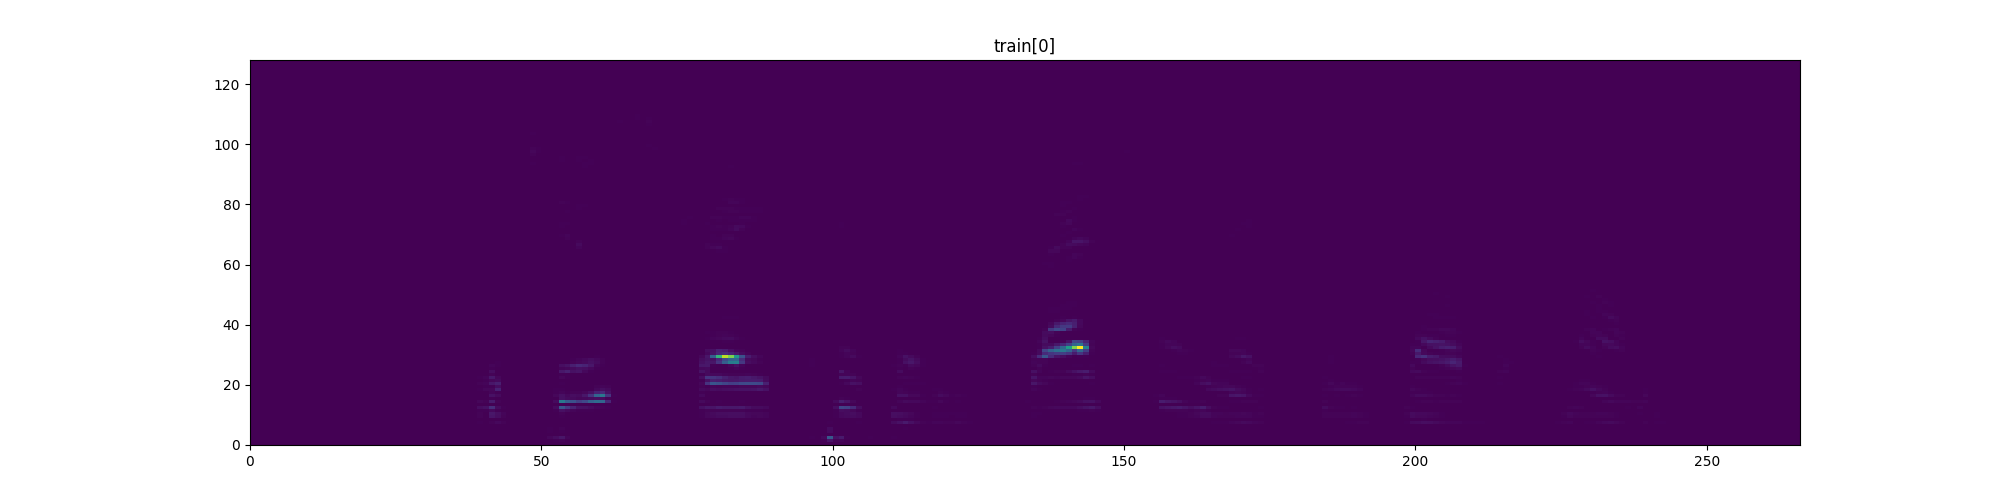

In [8]:
import IPython.display as ipd
import matplotlib.pyplot as plt
from IPython.display import display
import torchvision.transforms.functional as F

from src.logger.utils import plot_spectrogram

item = ds_train[0]

print("TEXT:")
print(item["text"][:200])

audio = item["audio"].squeeze(0).cpu().numpy()
display(ipd.Audio(audio, rate=ds_train.target_sr))


spec = item["spectrogram"]
spec2d = spec.squeeze(0)  

img = plot_spectrogram(spec2d, name="train[0]")


display(F.to_pil_image(img))


In [ ]:
from hydra import initialize, compose
from omegaconf import OmegaConf

overrides = [
    "datasets=onebatchtest",          
    "dataloader.batch_size=2",        
    "trainer.epoch_len=1",           
    "writer.mode=online",            
    "writer.run_name=onebatch_debug", 
    "trainer.n_epochs=1",            
]

with initialize(config_path="src/configs", version_base=None):
    cfg = compose(config_name="baseline", overrides=overrides)

print(OmegaConf.to_yaml(cfg, resolve=True))


model:
  _target_: src.model.BaselineModel
  n_feats: 128
  fc_hidden: 512
writer:
  _target_: src.logger.CometMLWriter
  project_name: ASR_HW
  workspace: progphys
  run_name: onebatch_debug
  mode: offline
  loss_names:
  - loss
  log_checkpoints: false
  id_length: 32
metrics:
  train: []
  inference:
  - _target_: src.metrics.ArgmaxCERMetric
    name: CER_(Argmax)
  - _target_: src.metrics.ArgmaxWERMetric
    name: WER_(Argmax)
datasets:
  train:
    _target_: src.datasets.LibrispeechDataset
    part: dev-clean
    max_audio_length: 20.0
    max_text_length: 200
    limit: 2
    instance_transforms:
      get_spectrogram:
        _target_: torchaudio.transforms.MelSpectrogram
        sample_rate: 16000
      audio:
        _target_: torchvision.transforms.v2.Compose
        transforms:
        - _target_: src.transforms.wav_augs.Gain
  val:
    _target_: src.datasets.LibrispeechDataset
    part: dev-clean
    max_audio_length: 20.0
    max_text_length: 200
    limit: 2
    instance